# Leitura e Formatação dos Dados de Desmatamento

In [11]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import MultiPolygon
from shapely.ops import transform
from pyproj import Proj, Transformer
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from rasterio.warp import reproject, Resampling


# Carregar o arquivo GeoPackage
gdf = gpd.read_file(r"G:\Meu Drive\Desmatamento - Alertas [2024-11]\deforestation_alerts_awa.gpkg")
gdf.columns

Index(['is_valid', 'analysis_date', 'area', 'location', 'source_images_date',
       'source_images', 'internal_storage_path', 'geometry'],
      dtype='object')

In [12]:
sorted(gdf['analysis_date'].unique())

[Timestamp('2023-08-26 00:00:00'),
 Timestamp('2023-09-01 00:00:00'),
 Timestamp('2023-09-10 00:00:00'),
 Timestamp('2023-09-15 00:00:00'),
 Timestamp('2023-09-20 00:00:00'),
 Timestamp('2023-09-25 00:00:00'),
 Timestamp('2023-09-30 00:00:00'),
 Timestamp('2023-10-05 00:00:00'),
 Timestamp('2023-10-10 00:00:00'),
 Timestamp('2023-10-15 00:00:00'),
 Timestamp('2023-10-20 00:00:00'),
 Timestamp('2023-10-25 00:00:00'),
 Timestamp('2023-10-30 00:00:00'),
 Timestamp('2023-11-04 00:00:00'),
 Timestamp('2023-11-09 00:00:00'),
 Timestamp('2023-11-14 00:00:00'),
 Timestamp('2023-11-19 00:00:00'),
 Timestamp('2023-11-24 00:00:00'),
 Timestamp('2023-11-29 00:00:00'),
 Timestamp('2023-12-09 00:00:00'),
 Timestamp('2023-12-14 00:00:00'),
 Timestamp('2023-12-19 00:00:00'),
 Timestamp('2023-12-24 00:00:00'),
 Timestamp('2023-12-29 00:00:00'),
 Timestamp('2024-01-03 00:00:00'),
 Timestamp('2024-01-08 00:00:00'),
 Timestamp('2024-01-13 00:00:00'),
 Timestamp('2024-01-18 00:00:00'),
 Timestamp('2024-01-

B04 Max: 9976.0 e Min: 0.0
B08 Max: 11975.0 e Min: 0.0


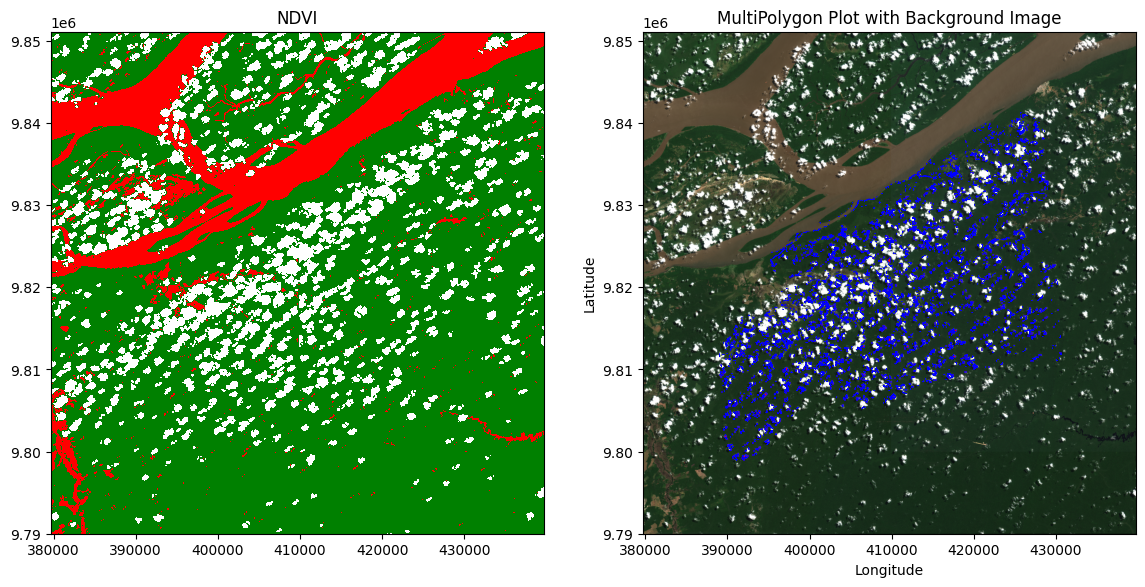

In [13]:
gdf_local = gdf[(gdf['analysis_date'] == '2023-08-26')].reset_index(drop=True)

# Caminho para a imagem
image_path = f"G:/Meu Drive/Desmatamento_Arquivos/awa/{gdf_local['internal_storage_path'][0]}/TCI_merged.tiff"
image_path_B04 = f"G:/Meu Drive/Desmatamento_Arquivos/awa/{gdf_local['internal_storage_path'][0]}/B04_merged.tiff"
image_path_B08 = f"G:/Meu Drive/Desmatamento_Arquivos/awa/{gdf_local['internal_storage_path'][0]}/B08_merged.tiff"
image_path_SCL = f"G:/Meu Drive/Desmatamento_Arquivos/awa/{gdf_local['internal_storage_path'][0]}/SCL_merged.tiff"

# Ler a imagem usando rasterio
with rasterio.open(image_path) as src:
    image = src.read([1, 2, 3]).transpose(1,2,0)  # Ler as três primeiras bandas (RGB)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    image_crs = src.crs  # Sistema de coordenadas da imagem
gdf_local= gdf_local.to_crs(image_crs)
# Sistema de coordenadas dos polígonos (supondo que seja WGS84)
#polygons_crs = 'EPSG:4326'

# Criar um transformador para converter as coordenadas
#transformer = Transformer.from_crs(polygons_crs, image_crs, always_xy=True)

# Função para transformar as coordenadas dos polígonos
#def transform_polygon(polygon):
#    return transform(transformer.transform, polygon)

# Supondo que row['geometry'] seja um objeto MultiPolygon
#multipolygon = gdf_awa['geometry'][0]

# Criar uma figura e um eixo
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Plotar a imagem de fundo
ax[1].imshow(np.squeeze(image), extent=extent)
        
del image #Libera memória        

#Abre a bandas 4 e 8 e calcula o NDVI
with rasterio.open(image_path_B04) as src:
    B04 = src.read(1).astype(float)
    B04 = B04.clip(min=0)
    #B04 = np.nan_to_num(B04,nan=0.0,posinf=0.0,neginf=0.0)
    B04_transform = src.transform
    B04_crs = src.crs
    print(f"B04 Max: {B04.max()} e Min: {B04.min()}")
    
with rasterio.open(image_path_B08) as src:
    B08 = src.read(1).astype(float)
    B08 = B08.clip(min=0)
    #B08 = np.nan_to_num(B08,nan=0.0,posinf=0.0,neginf=0.0)
    print(f"B08 Max: {B08.max()} e Min: {B08.min()}")
    
with rasterio.open(image_path_SCL) as scl_src:
    SCL = scl_src.read(1)
    SCL_transform = scl_src.transform
    SCL_crs = scl_src.crs
    #print(SCL.shape)
    # Reamostrar SCL para resolução de 10m
    scl_resampled = np.empty_like(B04, dtype=SCL.dtype)
    reproject(
        source=SCL,
        destination=scl_resampled,
        src_transform=scl_src.transform,
        src_crs=scl_src.crs,
        dst_transform=B04_transform,
        dst_crs=B04_crs,
        resampling=Resampling.nearest
    )

def calculate_ndvi(nir, red, epsilon=1e-10):
    """
    Calcula o NDVI (Normalized Difference Vegetation Index).

    Args:
    nir (numpy array): Reflectância no infravermelho próximo.
    red (numpy array): Reflectância no vermelho.
    epsilon (float): Pequena constante para evitar divisão por zero.

    Returns:
    numpy array: NDVI.
    """
    ndvi = (nir - red) / (nir + red + epsilon)
    return ndvi

    
# Calcular o NDVI
NDVI = calculate_ndvi(B08, B04)



del B04, B08 #Libera memória

# Identificar pixels do SCL com valores 0, 3, 8 e 9
mask_values = [0, 3, 8, 9]
mask = np.isin(scl_resampled, mask_values)

NDVI[mask] = 2

# Definir o colormap personalizado: azul para valores negativos, preto para 0-0.35, gradiente para o resto
colors = ['red', 'green','white']  # Cores para cada faixa
bounds = [-1, 0.36, 1.1, 2]  # Intervalos dos valores de NDVI
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

# Plotar o NDVI
ax[0].imshow(NDVI, cmap=cmap, norm=norm, extent=extent)

#gdf_local.plot(ax=ax[0], color='red')
gdf_local.plot(ax=ax[1], color='red', edgecolor='blue', lw=0.5)
# Configurar os eixos
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax[1].set_title('MultiPolygon Plot with Background Image')
ax[0].set_title('NDVI')
# Mostrar o gráfico
plt.show()

In [20]:
import numpy as np
from shapely.geometry import MultiPolygon, Polygon
from rasterio.features import geometry_mask

def check_ndvi_numpy(gdf_local, ndvi_array, transform, threshold=0.35):
    """
    Verifica se os valores de NDVI dentro dos MultiPolígonos são menores que um limiar.
    
    Args:
        gdf_local (GeoDataFrame): Polígonos de interesse (MultiPolígonos).
        ndvi_array (numpy.ndarray): Matriz NDVI.
        transform (Affine): Transformação espacial (resolução e origem do NDVI).
        threshold (float): Limiar de NDVI a ser verificado.
    
    Returns:
        dict: Dicionário com os resultados por MultiPolígono.
    """
    results = {}
    
    for idx, row in gdf_local.iterrows():
        geometry = row['geometry']
        
        # Garantir que a geometria é um MultiPolygon
        if isinstance(geometry, Polygon):
            multipolygon = [geometry]  # Caso seja um único polígono
        elif isinstance(geometry, MultiPolygon):
            multipolygon = list(geometry.geoms)  # Lista de polígonos individuais
        else:
            continue  # Pular geometrias inválidas
        
        ndvi_values = []  # Lista para armazenar valores NDVI dentro dos polígonos
        
        # Iterar sobre cada polígono no MultiPolygon
        for polygon in multipolygon:
            try:
                # Criar máscara booleana a partir do polígono
                mask = geometry_mask(
                    geometries=[polygon],
                    out_shape=ndvi_array.shape,
                    transform=transform,
                    invert=True  # Inverter para que a área do polígono seja True
                )
                
                # Extrair os valores NDVI onde a máscara é True
                valid_ndvi = ndvi_array[mask]
                
                if valid_ndvi.size > 0:
                    ndvi_values.extend(valid_ndvi)
            except Exception as e:
                print(f"Erro ao processar polígono {idx}: {e}")
        
        # Calcular estatísticas para o MultiPolygon
        if len(ndvi_values) > 0:
            mean_ndvi = np.mean(ndvi_values)
            below_threshold = (np.array(ndvi_values) < threshold).sum() / len(ndvi_values) * 100  # % abaixo do limiar
            
            results[idx] = {
                'mean_ndvi': mean_ndvi,
                'percent_below_threshold': below_threshold,
                'valid': below_threshold > 40  # Exemplo: válido se > 50% dos pixels estão abaixo do limiar
            }
        else:
            results[idx] = {'mean_ndvi': None, 'percent_below_threshold': 0, 'valid': False}
    
    return results

# Executar a função
results = check_ndvi_numpy(gdf_local, NDVI, B04_transform, threshold=0.36)
cont = 0
# Exibir os resultados
for idx, res in results.items():
    print(f"MultiPolígono {idx}:")
    print(f"  Média NDVI: {res['mean_ndvi']}")
    print(f"  % Pixels abaixo de {0.36}: {res['percent_below_threshold']:.2f}%")
    print(f"  Válido: {'Sim' if res['valid'] else 'Não'}\n")
    if res['valid']:
        cont += 1
print(f"Total de polígonos válidos: {cont}")

MultiPolígono 0:
  Média NDVI: 0.333990492674934
  % Pixels abaixo de 0.36: 69.64%
  Válido: Sim

MultiPolígono 1:
  Média NDVI: 0.3535616549590453
  % Pixels abaixo de 0.36: 52.21%
  Válido: Sim

MultiPolígono 2:
  Média NDVI: 0.3347179921058343
  % Pixels abaixo de 0.36: 69.93%
  Válido: Sim

MultiPolígono 3:
  Média NDVI: 0.3151241613895792
  % Pixels abaixo de 0.36: 79.05%
  Válido: Sim

MultiPolígono 4:
  Média NDVI: 0.3490081100300452
  % Pixels abaixo de 0.36: 59.38%
  Válido: Sim

MultiPolígono 5:
  Média NDVI: 0.33704990848646305
  % Pixels abaixo de 0.36: 68.53%
  Válido: Sim

MultiPolígono 6:
  Média NDVI: 0.3394941500095493
  % Pixels abaixo de 0.36: 63.57%
  Válido: Sim

MultiPolígono 7:
  Média NDVI: 0.3378102219819789
  % Pixels abaixo de 0.36: 63.34%
  Válido: Sim

MultiPolígono 8:
  Média NDVI: 0.3113887222258484
  % Pixels abaixo de 0.36: 80.76%
  Válido: Sim

MultiPolígono 9:
  Média NDVI: 0.3368750021013778
  % Pixels abaixo de 0.36: 67.01%
  Válido: Sim

MultiPolíg